# 18. Advanced Time Series Topics

## 18.1. Infinite Distributed Lag Models

$$y_t = \alpha_0 + \gamma z_t + \rho y_{t-1} + \nu_t$$

$$LRP = \frac{\gamma}{1 - \rho}$$

### Rational distributed lag model

$$y_t = \alpha_0 + \gamma_0 z_t + \rho y_{t-1} + \gamma_1 z_{t-1} + \nu_t$$

$$LRP = \frac{\gamma_0 + \gamma_1}{1 - \rho}$$

### Example 18.1: Housing Investment and Residential Price Inflation

#### Note on _sm.tsa.tsatools.detrend(y)_: returns the error of the following regression $y_t = t^1 + t^2 . . . +t^p + \epsilon_t$

In [1]:
import wooldridge as woo
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
from supplementaryFunctions import *

<AxesSubplot:>

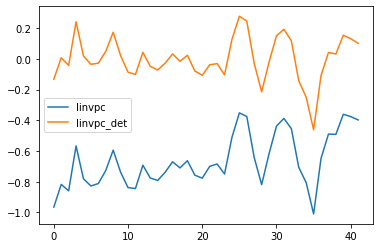

In [2]:
hseinv = woo.dataWoo("hseinv")

# add lags and detrend
p = 1
hseinv["linvpc_det"] = sm.tsa.tsatools.detrend(hseinv["linvpc"], order =p)

# detrend performs the following
# hseinv["time"] = np.arange(len(hseinv))

# hseinv["linvpc_det"] = smf.ols(formula = "linvpc ~ I(time ** p)", 
#                               data = hseinv).fit().resid
hseinv[["linvpc", "linvpc_det"]].plot()

In [3]:
hseinv["gprice_lag1"] = hseinv["gprice"].shift()
hseinv["linvpc_det_lag1"] = hseinv["linvpc_det"].shift()

formula = "linvpc_det ~ gprice + linvpc_det_lag1"
reg_koyck = smf.ols(formula=formula,
                   data = hseinv)
results_koyck = reg_koyck.fit()

OLS_summary(results_koyck)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.4067$$,,,,
Intercept,-0.0100,-0.5561,0.5814,0.0179
gprice,3.0948,3.3159,0.0020,0.9333
linvpc_det_lag1,0.3399,2.5831,0.0138,0.1316


In [4]:
# rational d.l.
formula = "linvpc_det ~ gprice + linvpc_det_lag1 + gprice_lag1"
reg_rational = smf.ols(formula=formula,
                   data = hseinv)
results_rational = reg_rational.fit()
OLS_summary(results_rational)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.542$$,,,,
Intercept,0.0059,0.3466,0.7309,0.0169
gprice,3.2564,3.3559,0.0019,0.9703
linvpc_det_lag1,0.5472,3.6076,0.0009,0.1517
gprice_lag1,-2.9363,-3.0172,0.0047,0.9732


In [5]:
tests = {"LRP":{}}
gamma = results_koyck.params["gprice"]
rho = results_koyck.params["linvpc_det_lag1"]
tests["LRP"]["Koyck"] =  gamma/ (1 - rho)
gamma0, gamma1 = results_rational.params["gprice"], results_rational.params["gprice_lag1"]
tests["LRP"]["Rational"] = (gamma0 + gamma1) / (1 - rho)
pd.DataFrame(tests)

,LRP
Koyck,4.688434
Rational,0.484785


## 18.2. Testing for Unit Roots

### Example 18.4: Unit Root in Real GDP

#### Augmented Dickey Fuller Test

ADF tests for unit root. It is a development of the Dickey-Fuller Test. It adds a differenced lag and a time trend variable.

$$\Delta y = \alpha + \theta y_{t-1} + \gamma_1 \Delta y_{t-1} + \delta t + e_t $$

In [6]:
inven = woo.dataWoo("inven")
inven["lgdp"] = np.log(inven["gdp"])

# ADF
diffs = 2
diff_data = {"data":inven["lgdp"],
            "Diff":inven["lgdp"].diff(),
            "2Diff":inven["lgdp"].diff().diff()}
tests = {}
for diff, data in diff_data.items():
    tests[diff] = {}
    res_ADF_aut = sm.tsa.stattools.adfuller(data.dropna(), maxlag = 1, autolag = None,
                                           regression="ct", regresults = True)
    tests[diff]["ADF"] = res_ADF_aut[0]
    tests[diff]["p-value"] = res_ADF_aut[1]
pd.DataFrame(tests).T

,ADF,p-value
data,-2.420733,0.368656
Diff,-5.069139,0.000154
2Diff,-6.085016,0.000001


## 17.3. Spurious Regression

$$x_t = x_{t-1} + a_t$$

$$y_t = y_{t-1} + e_t$$

In [7]:
plt.rcParams.update({"font.size":32})
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.005
n = 51
num_sims = 1000
results_dict = {"p-value":{},
                "$r^2$":{}}
diff_results_dict = {"p-value":{},
                     "$r^2$":{}}
sim_dict = {"Data":{},
           "Diff":{}}
for i in range(num_sims):
    e = stats.norm.rvs(0, 1, size = n)
    e[0] = 0
    a = stats.norm.rvs(0, 1, size = n)
    a[0] = 0

    # independent random  walks:
    x = np.cumsum(a)
    y = np.cumsum(e)
    sim_data = pd.DataFrame({"y":y, "x":x})
    sim_dict["Data"][i] = sim_data 
    reg = smf.ols(formula="y ~ x",
                 data = sim_data)
    results = reg.fit()
    results_dict["p-value"][i] = results.pvalues["x"]
    results_dict["$r^2$"][i] = results.rsquared

    
    sim_dict["Diff"][i] = sim_data.diff().dropna()
    diff_reg = smf.ols(formula="y ~ x",
                 data = sim_data.diff().dropna())
    diff_results = diff_reg.fit()
    diff_results_dict["p-value"][i] = diff_results.pvalues["x"]
    diff_results_dict["$r^2$"][i] = diff_results.rsquared
    
    
    
results_df = pd.DataFrame(results_dict)    
results_df

,p-value,$r^2$
0,4.285643e-06,0.353084
1,1.643984e-01,0.039074
2,2.447885e-01,0.027505
3,3.716549e-09,0.511475
4,8.515124e-10,0.539524
...,...,...
995,1.402480e-03,0.189669
996,4.487748e-10,0.551223
997,1.596187e-02,0.112827
998,3.479777e-02,0.087753


In [8]:
diff_results_df = pd.DataFrame(diff_results_dict)
diff_results_df

,p-value,$r^2$
0,0.719624,2.708873e-03
1,0.928902,1.675855e-04
2,0.180296,3.708476e-02
3,0.284771,2.379841e-02
4,0.179400,3.723487e-02
...,...,...
995,0.719633,2.708678e-03
996,0.401612,1.470026e-02
997,0.993856,1.248104e-06
998,0.834108,9.229609e-04


#### The presence of a unit root incorrectly generates a false positive. Instead of only $\approx 5\%$ of results being statistically significant at the 5\% level, around two thirds is statistically significant. If we difference the data, this effect is lost, and $\approx 5\%$ have a statistical significance of 5\%.

In [9]:
results_df[results_df["p-value"] < 0.05].shape[0] / 1000

0.641

In [10]:
diff_results_df[diff_results_df["p-value"] < 0.05].shape[0] / 1000

0.051

In [11]:
results_df[results_df["$r^2$"] > 0.2]


,p-value,$r^2$
0,4.285643e-06,0.353084
3,3.716549e-09,0.511475
4,8.515124e-10,0.539524
5,8.083092e-07,0.394422
6,5.773306e-08,0.454811
...,...,...
986,1.267781e-15,0.732139
987,2.716990e-04,0.239092
988,2.035189e-06,0.371850
993,3.984365e-07,0.411199


Text(0.5, 1.0, 'Simulation 1\np-value    0.164398\n$r^2$      0.039074\nName: 1, dtype: float64')

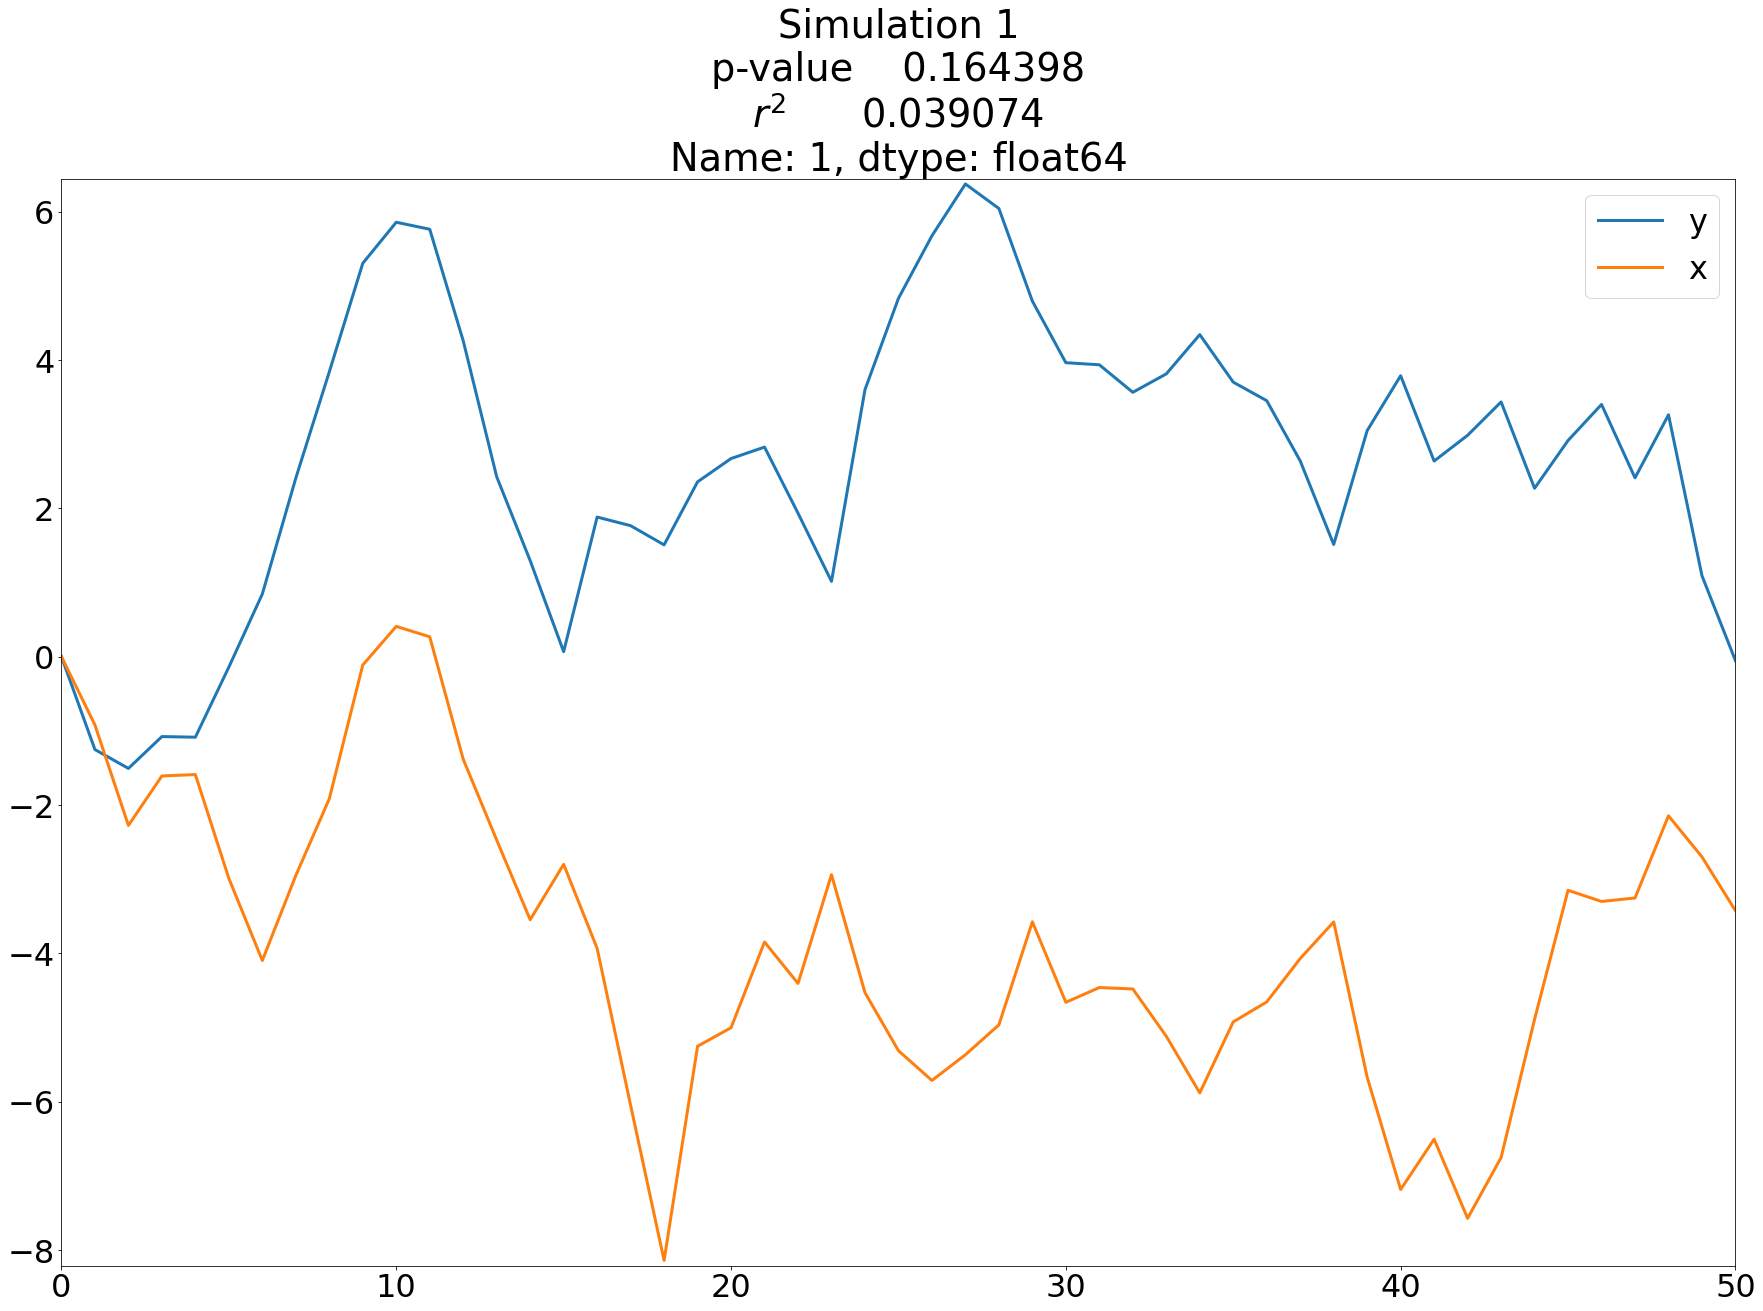

In [18]:
i = 1
fig, ax = plt.subplots(figsize = (30,20))
sim_dict["Data"][i].plot.line(ax = ax, linewidth = 3)
plt.title("Simulation " + str(i) + "\n" + str(results_df.iloc[i]))

Text(0.5, 1.0, 'Simulation 1\np-value    0.928902\n$r^2$      0.000168\nName: 1, dtype: float64')

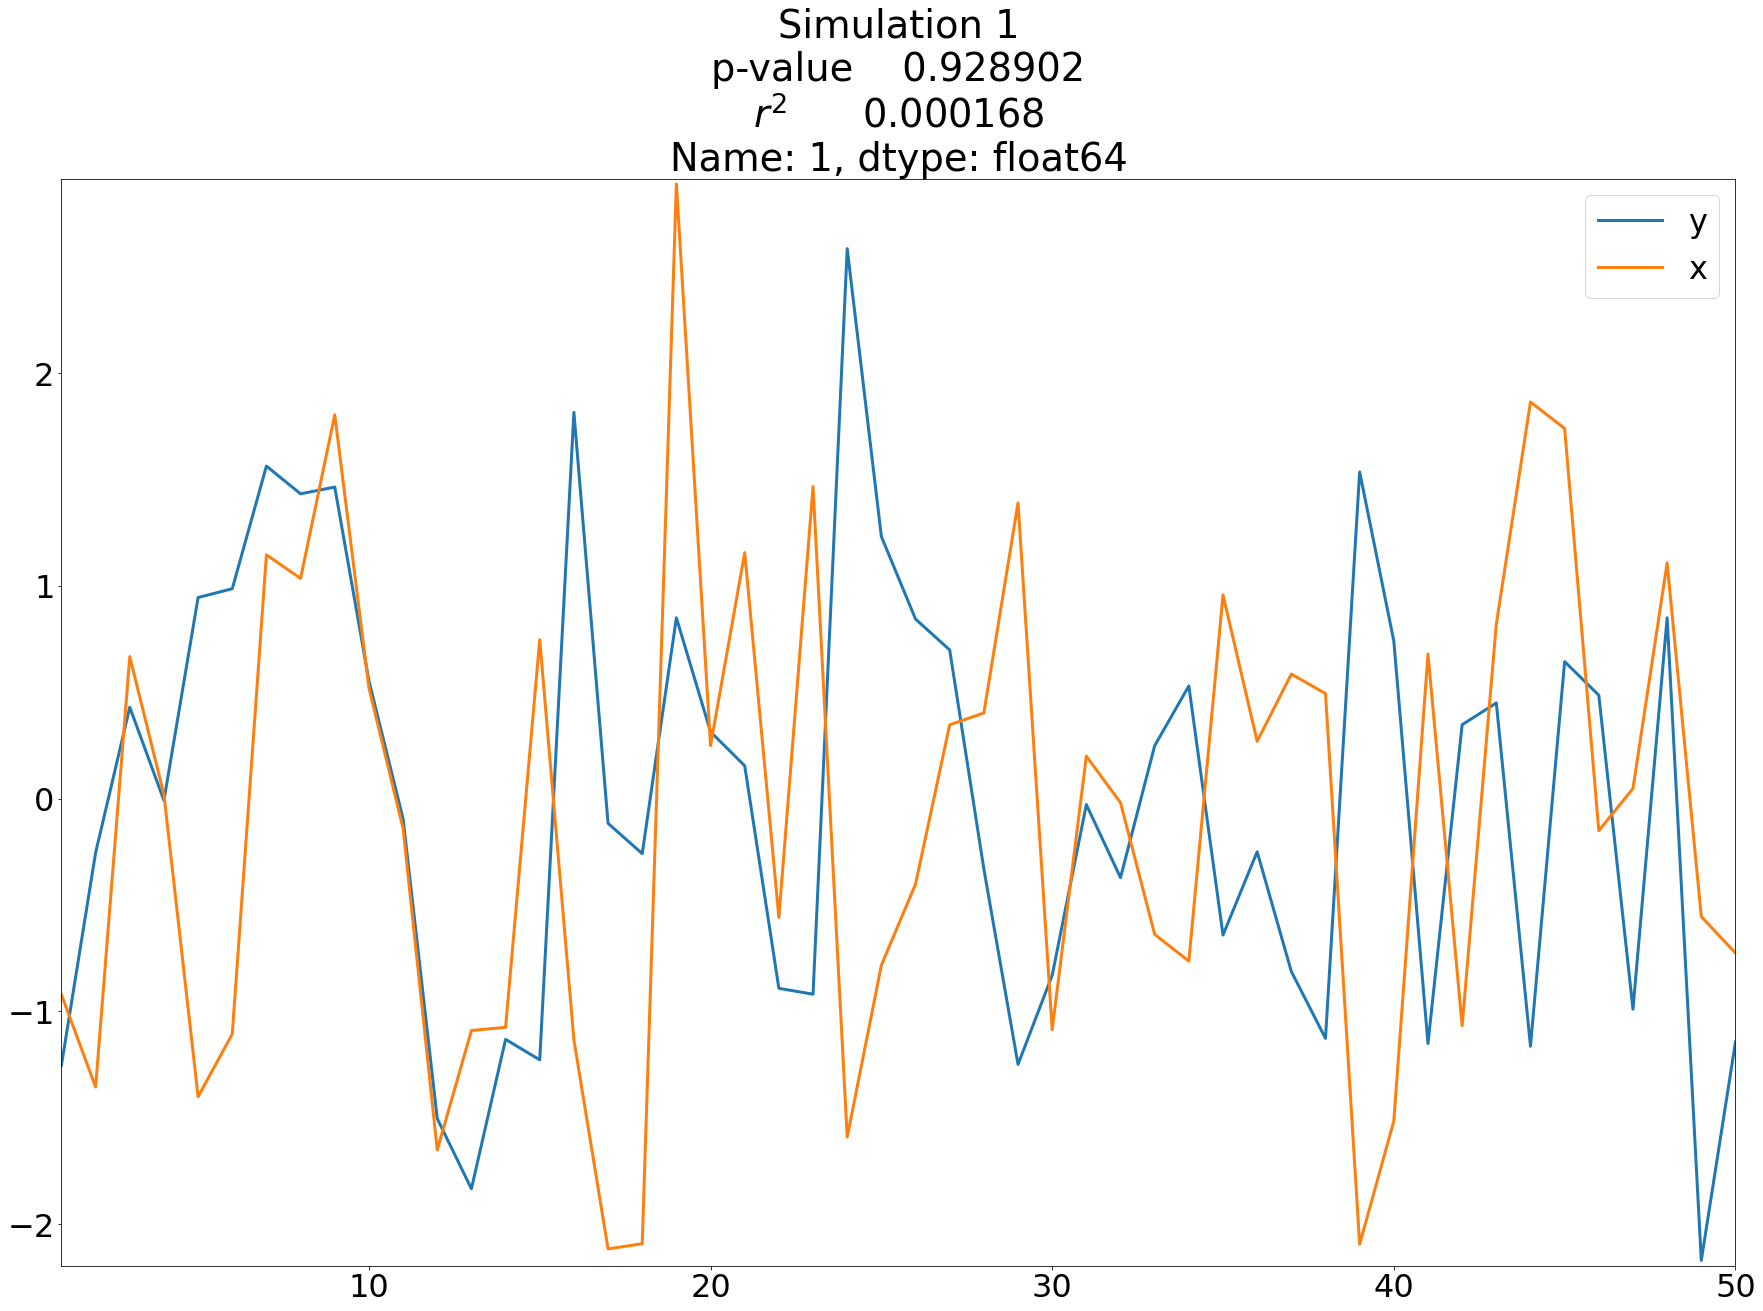

In [19]:
fig, ax = plt.subplots(figsize = (30,20))
sim_dict["Diff"][1].plot.line(ax = ax, linewidth = 3)
plt.title("Simulation " + str(i) + "\n" + str(diff_results_df.iloc[i]))

$$y_t = \delta_0 + \alpha_1 y_{t-1} + \gamma_1 z_{t-1} + u_t$$

if $E(u_t|I_{t-1}) = 0 $:
    
$$E(y_{t+1}|I_t) = \delta_0 + \alpha_1 y_t + \gamma_1 z_t$$

$$e_t = y_t - f_t$$

$$RMSE = \sqrt{\frac{1}{m}}\sum_{h=1}^{m}{e_{n+h}^2}$$

$$MAE = \frac{1}{m}\sum_{h=1}^{m}{|e_{n+h}|}$$

### Example 18.8: Forecasting the U.S. Unemployment Rate

In [22]:
phillips = woo.dataWoo("phillips")
pd.to_datetime(phillips["year"])
phillips.set_index("year", inplace = True)
phillips

,unem,inf,inf_1,unem_1,cinf,cunem
year,,,,,,
1948,3.8,8.1,NaN,NaN,NaN,NaN
1949,5.9,-1.2,8.1,3.8,-9.3,2.100000
1950,5.3,1.3,-1.2,5.9,2.5,-0.600000
1951,3.3,7.9,1.3,5.3,6.6,-2.000000
1952,3.0,1.9,7.9,3.3,-6.0,-0.300000
1953,2.9,0.8,1.9,3.0,-1.1,-0.100000
1954,5.5,0.7,0.8,2.9,-0.1,2.600000
1955,4.4,-0.4,0.7,5.5,-1.1,-1.100000
1956,4.1,1.5,-0.4,4.4,1.9,-0.300000


In [38]:
#estimate models
yt96 = phillips.index <= 1996
yf97 = phillips.index > 1996
formula1 = "unem ~ unem_1"
formula2 = formula1 + " + inf_1"
results, reg, pred, predict_stats = {}, {}, {}, {}

for formula in [formula1, formula2]:
    reg[formula] = smf.ols(formula = formula, 
                               data = phillips,
                               subset = yt96)
    results[formula] = reg[formula].fit()
    pred[formula] = results[formula].get_prediction(phillips[yf97]).summary_frame(alpha=0.05)
    pred[formula].index = phillips[yf97].index
    
    #forecast error
    e = phillips[yf97]["unem"].sub(pred[formula]["mean"])
    predict_stats[formula] = {"rmse":np.sqrt(np.mean(e **2)),
                             "mae":np.mean(abs(e))}
pd.DataFrame(predict_stats)
    

,unem ~ unem_1,unem ~ unem_1 + inf_1
rmse,0.576120,0.521754
mae,0.542014,0.484195
